In [13]:
!pip install google-api-python-client

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from googleapiclient.discovery import build 
import pandas as pd 
import numpy as np

api_key = "YOUR_YOUTUBE_API_KEY"
channel_ids = [
    'UCAq9f7jFEA7Mtl3qOZy2h1A',  # Zach Wilson
    'UCChmJrVa8kDg05JfCmxpLRw',  # Darshil Parmar
    'UCkHdBeQ4DuvBXTahMYZVlMA',  # Kenji Explains
    'UC7cs8q-gJRlGwj4A8OmCmXg',  # Alex the Analyst
    'UCtoNXlIegvxkvf5Ji8S57Ag',  # Lore So What
    'UCLLw7jmFsvfIVaUFsLs8mlQ',  # Luke Barousse
    'UCD7FERT7OXNgLYkvEyy3qGQ',  # Zero Analyst
]

# Initialize the YouTube API client
youtube = build('youtube', 'v3', developerKey=api_key)

In [17]:

def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    # API request to get channel data
    request = youtube.channels().list(
        part='snippet,contentDetails,statistics',
        id= ','.join(channel_ids)
    )
    
    # Execute the request and store the response
    response = request.execute()
    
    # Loop through each channel's response and extract relevant data
    for i in range(len(response['items'])):
        data = {
            'channel_name': response['items'][i]['snippet']['title'],
            'subscribers': response['items'][i]['statistics']['subscriberCount'],
            'total_video': response['items'][i]['statistics']['videoCount'],
            'total_view': response['items'][i]['statistics']['viewCount'],
            'playlist_id': response['items'][i]['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    
    return all_data

channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

[{'channel_name': 'Zero Analyst',
  'subscribers': '16500',
  'total_video': '249',
  'total_view': '356391',
  'playlist_id': 'UUD7FERT7OXNgLYkvEyy3qGQ'},
 {'channel_name': 'Alex The Analyst',
  'subscribers': '909000',
  'total_video': '333',
  'total_view': '41995794',
  'playlist_id': 'UU7cs8q-gJRlGwj4A8OmCmXg'},
 {'channel_name': 'Darshil Parmar',
  'subscribers': '159000',
  'total_video': '158',
  'total_view': '7726373',
  'playlist_id': 'UUChmJrVa8kDg05JfCmxpLRw'},
 {'channel_name': 'Luke Barousse',
  'subscribers': '480000',
  'total_video': '160',
  'total_view': '23782523',
  'playlist_id': 'UULLw7jmFsvfIVaUFsLs8mlQ'},
 {'channel_name': 'Kenji Explains',
  'subscribers': '628000',
  'total_video': '213',
  'total_view': '39033711',
  'playlist_id': 'UUkHdBeQ4DuvBXTahMYZVlMA'},
 {'channel_name': 'Data with Zach',
  'subscribers': '71500',
  'total_video': '48',
  'total_view': '1301110',
  'playlist_id': 'UUAq9f7jFEA7Mtl3qOZy2h1A'},
 {'channel_name': 'Lore So What',
  'subsc

In [18]:
# Store the retrieved data into a Pandas DataFrame
channel_data = pd.DataFrame(channel_stats)

# Convert specific columns to numeric data types for analysis
channel_data['subscribers'] = pd.to_numeric(channel_data['subscribers'])
channel_data['total_video'] = pd.to_numeric(channel_data['total_video'])
channel_data['total_view'] = pd.to_numeric(channel_data['total_view'])
channel_data

,channel_name,subscribers,total_video,total_view,playlist_id
0,Zero Analyst,16500,249,356391,UUD7FERT7OXNgLYkvEyy3qGQ
1,Alex The Analyst,909000,333,41995794,UU7cs8q-gJRlGwj4A8OmCmXg
2,Darshil Parmar,159000,158,7726373,UUChmJrVa8kDg05JfCmxpLRw
3,Luke Barousse,480000,160,23782523,UULLw7jmFsvfIVaUFsLs8mlQ
4,Kenji Explains,628000,213,39033711,UUkHdBeQ4DuvBXTahMYZVlMA
5,Data with Zach,71500,48,1301110,UUAq9f7jFEA7Mtl3qOZy2h1A
6,Lore So What,102000,160,1560280,UUtoNXlIegvxkvf5Ji8S57Ag


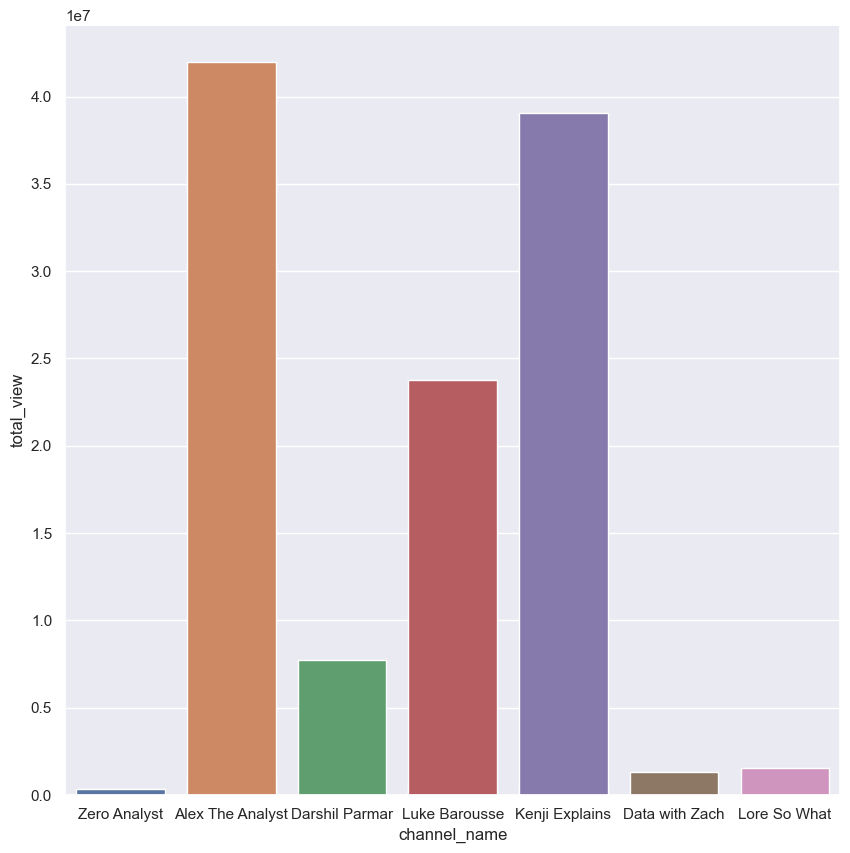

In [19]:
import seaborn as sns  # Import Seaborn for visualization

# Set the figure size for better readability
sns.set(rc={'figure.figsize':(10, 10)})

# Create a bar plot for subscriber count per channel
ax1 = sns.barplot(x='channel_name', y='subscribers', data=channel_data)

# Create a bar plot for total views per channel
ax2 = sns.barplot(x='channel_name', y='total_view', data=channel_data)


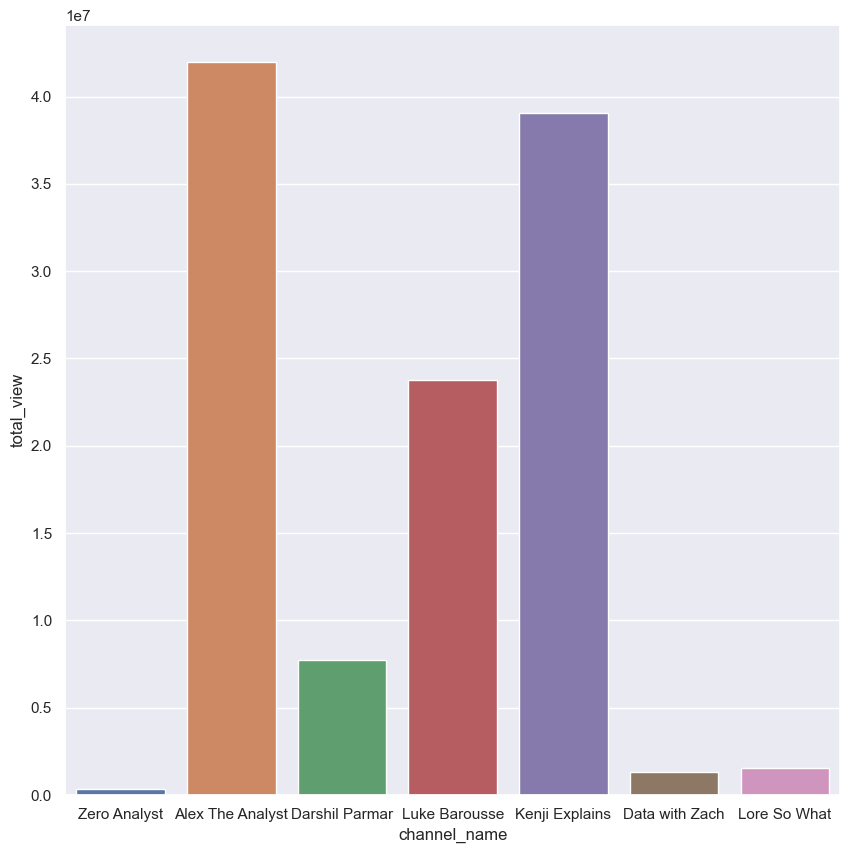

In [20]:
# Create a bar plot for total views per channel
ax2 = sns.barplot(x='channel_name', y='total_view', data=channel_data)

In [21]:
# Retrieve playlist ID for a specific channel ('Alex The Analyst' in this case)
playlist_id = channel_data.loc[channel_data['channel_name'] == 'Alex The Analyst', 'playlist_id'].iloc[0]
playlist_id


'UU7cs8q-gJRlGwj4A8OmCmXg'

In [22]:

def get_video_ids(youtube, playlist_id):
    # Initial request to get the first page of playlist items
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    video_ids = []

    # Loop through the first set of videos and append their video IDs
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    # Check if there are more pages of results
    next_page_token = response.get('nextPageToken')
    
    while next_page_token:
        # Request the next set of results if there's a next page
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()

        # Append video IDs from the next page
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        # Update next page token for pagination
        next_page_token = response.get('nextPageToken')

    return video_ids

video_ids = get_video_ids(youtube, playlist_id)
video_ids


['tnz72ywhCoo',
 'j8FSP8XuFyk',
 'zXnQNytHCPM',
 'osA1QpBcxRs',
 'Mdq1WWSdUtw',
 'CZt2BUpgjgw',
 't1fQBD4B7xk',
 'OT1RErkfLNQ',
 'rxyLC247h6E',
 'AycpRKyRagE',
 'K2GfrERtliU',
 'xmVyaT-RuVo',
 'amb9bciHGSI',
 'hgaVi4sOHkM',
 'YSjbGET6R1A',
 'vDVcXXfc9e8',
 'Vg6ys_JvXzg',
 'sge9qTf8GdY',
 '9ur0OpMADuM',
 'UTMuL_86gSQ',
 'sEImMaovc1Q',
 'ZYps6TmBkWk',
 'zv1nfZTYpio',
 'rn0dSsYXhIE',
 'siHou7lObbo',
 'wJiJXD7MVoY',
 'BzwAZ1k3WEY',
 '5q2u8__sVhs',
 'UJbNEH0_nGY',
 'oz2K4HUNMW4',
 'Y-4ri9QjsTI',
 'F5v2dRYU5IA',
 '_R6K1aNtKpE',
 '5tKmTdvEAVk',
 'QYd-RtK58VQ',
 'c5ko0sedE7k',
 '4UltKCnnnTA',
 'BV5ckMNNvi4',
 'QMUZ5HfWMRc',
 '7b8ViCqD9JM',
 '7vnxpcqmqNQ',
 'uEk07jXdKOo',
 'UC7uvOqcUTs',
 '1KEbiqRWOkA',
 'UOBTLzWY1vs',
 '8zOkBTs0yxs',
 '7NBt0V8ebGk',
 'FGC0cCAgGu0',
 'Vj6RqA_X-IE',
 'RYIiOG4LsvQ',
 '5y7tLNPVJPA',
 '_nf56aMPdZE',
 'XbDRYzYUmMo',
 'KRXSJb9ql1Y',
 'iTQW_nDp938',
 'lXQzD09BOH0',
 'xtC3212t4hI',
 'KZKizyBS9YM',
 'I0_ca6iyo6w',
 'GZS7AgQ4Ksg',
 'fT-8mRf_-Hk',
 'ZHaYOC0H5KE',
 'K0-8G3

In [23]:

def get_video_details(youtube, video_ids):
    all_video_stats = []
    
    # Loop over video IDs in chunks of 50
    for i in range(0, len(video_ids), 50):
        # Request video data for a batch of 50 videos at a time
        request = youtube.videos().list(
            part='snippet,statistics',  # Include video snippet and statistics
            id=','.join(video_ids[i:i+50])  # Join video IDs into a single string
        )
        response = request.execute()

        # Process each video in the response
        for video in response['items']:
            # Extract video statistics and create a dictionary
            video_stats = {
                'Title': video['snippet']['title'],
                'Published_date': video['snippet']['publishedAt'],
                'Views': video['statistics']['viewCount'],
                'Likes': video['statistics']['likeCount'],
                'Comments': video['statistics']['commentCount']
            }
            
            # Append the video stats to the list
            all_video_stats.append(video_stats)
    
    return all_video_stats

video_details = get_video_details(youtube, video_ids)
video_details


[{'Title': 'Coding with R and AI Now on Analyst Builder!',
  'Published_date': '2024-11-12T13:01:10Z',
  'Views': '2638',
  'Likes': '114',
  'Comments': '13'},
 {'Title': 'Learn Tableau in Under 2 hours | Dashboards, Relationships, Visualizations + Mini Project',
  'Published_date': '2024-11-05T13:01:16Z',
  'Views': '8946',
  'Likes': '385',
  'Comments': '21'},
 {'Title': 'Learn Excel in Under 3 Hours | Pivot Tables, Lookups, Data Cleaning',
  'Published_date': '2024-10-29T12:01:19Z',
  'Views': '19720',
  'Likes': '836',
  'Comments': '38'},
 {'Title': 'Nobody cares... so just do it!',
  'Published_date': '2024-10-24T12:17:57Z',
  'Views': '8743',
  'Likes': '869',
  'Comments': '42'},
 {'Title': 'Learn Pandas in Under 3 Hours | Filtering, Joins, Indexing, Data Cleaning, Visualizations',
  'Published_date': '2024-10-22T12:00:28Z',
  'Views': '12948',
  'Likes': '538',
  'Comments': '24'},
 {'Title': 'Free Data Analyst Bootcamp 2024',
  'Published_date': '2024-10-17T11:52:50Z',
  'V

In [24]:
# Store the retrieved video data in a Pandas DataFrame
video_data = pd.DataFrame(video_details)

# Convert the 'Published_date' column to datetime and extract the date
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date

# Convert numeric columns to appropriate types
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Comments'] = pd.to_numeric(video_data['Comments'])

# Display the video data
video_data


,Title,Published_date,Views,Likes,Comments
0,Coding with R and AI Now on Analyst Builder!,2024-11-12,2638,114,13
1,"Learn Tableau in Under 2 hours | Dashboards, R...",2024-11-05,8946,385,21
2,"Learn Excel in Under 3 Hours | Pivot Tables, L...",2024-10-29,19720,836,38
3,Nobody cares... so just do it!,2024-10-24,8743,869,42
4,"Learn Pandas in Under 3 Hours | Filtering, Joi...",2024-10-22,12948,538,24
...,...,...,...,...,...
328,Data Analyst Resume | Reviewing My Resume! | F...,2020-01-30,76815,1715,63
329,Working at a Big Company Vs Small Company | To...,2020-01-25,15546,414,22
330,Data Analyst Salary | 100k with No Experience,2020-01-23,65697,2230,231
331,Truth About Big Companies | Told by a Fortune ...,2020-01-21,9360,339,20


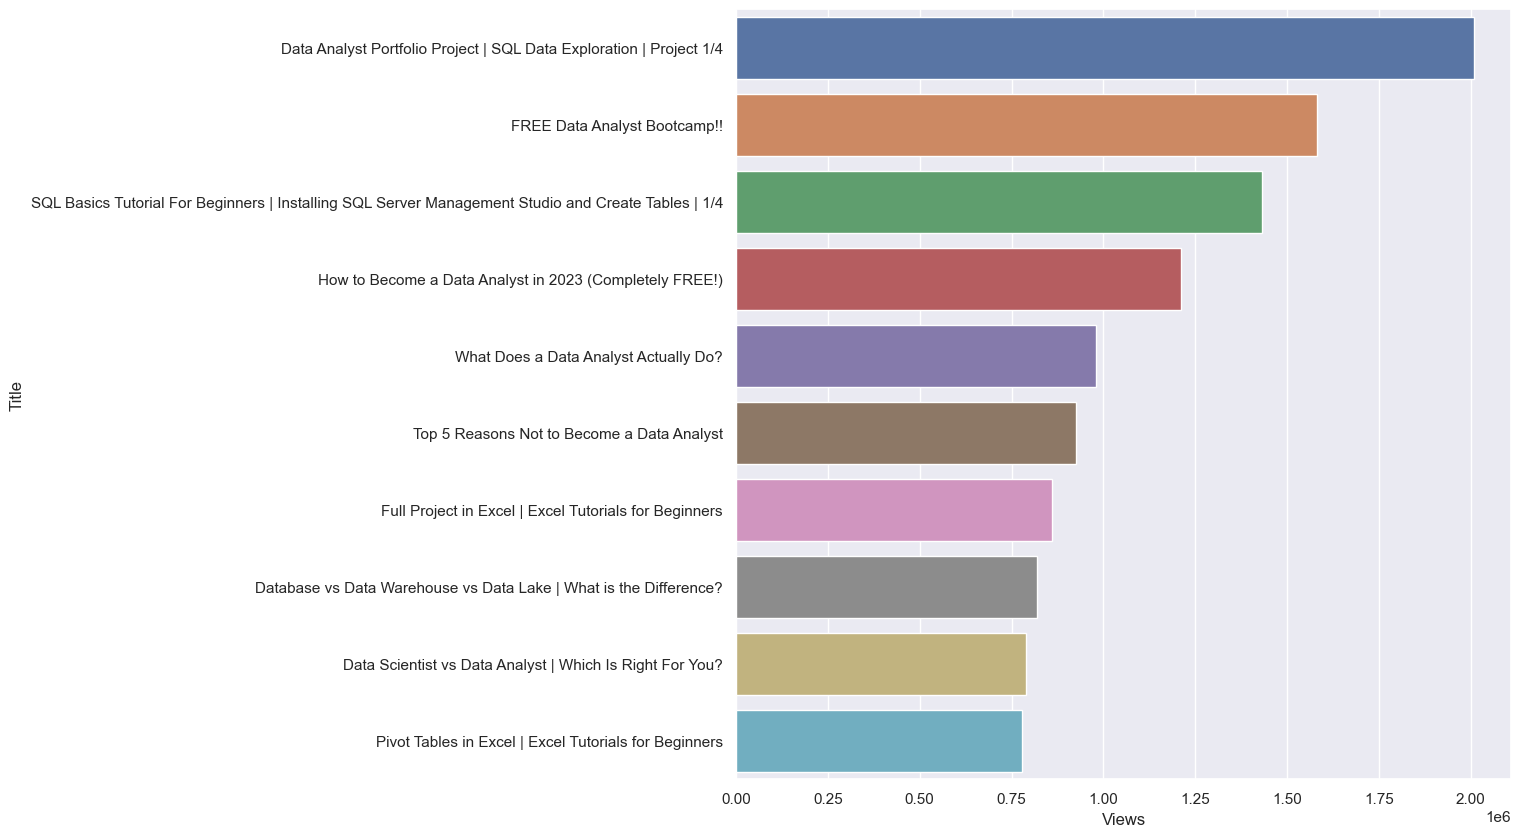

In [25]:
# Sort the data by views in descending order and display the top 10 most viewed videos
top10_videos = video_data.sort_values(by='Views', ascending=False).head(10)

# Create a bar plot showing the top 10 videos by views
ay1 = sns.barplot(x='Views', y='Title', data=top10_videos)


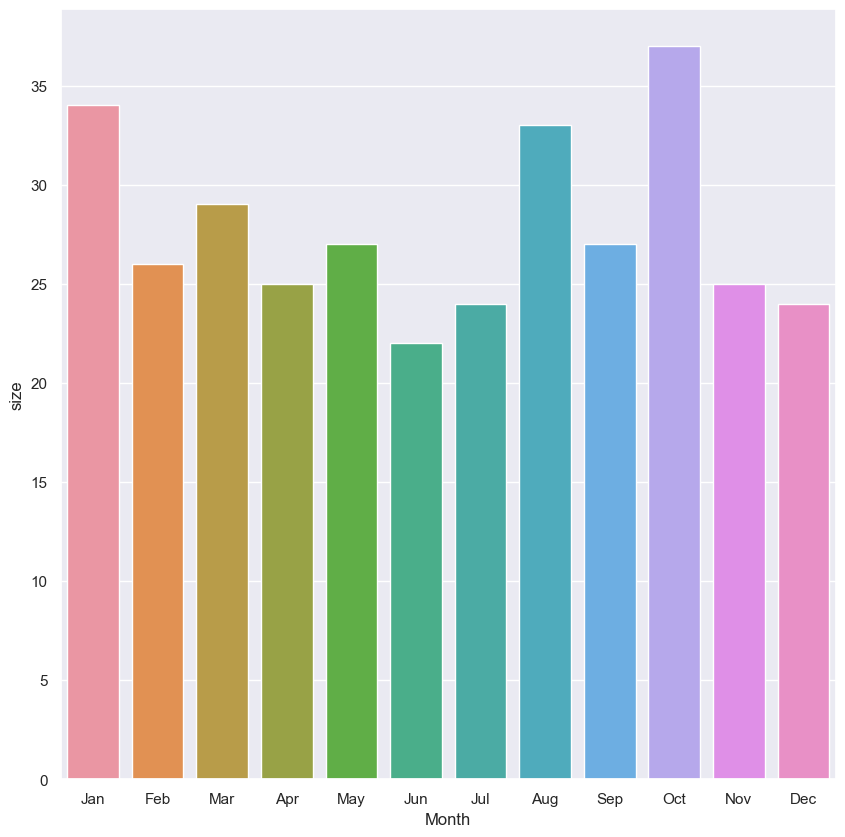

In [26]:
# Extract the month from the 'Published_date' column
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

# Group the data by month and count the number of videos per month
videos_per_month = video_data.groupby('Month', as_index=False).size()

# Sort the months in calendar order
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)
videos_per_month = videos_per_month.sort_index()

# Create a bar plot showing the number of videos per month
ay2 = sns.barplot(x='Month', y='size', data=videos_per_month)
